# Ingest explations into array

In [1]:
import os
# Set environment variables to disable multithreading
# as users will probably want to set the number of cores
# to the max of their computer.
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


In [10]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from astroExplain.spectra.explanation import TellMeWhy
from anomaly.utils import specobjid_to_idx
from autoencoders.ae import AutoEncoder
from sdss.metadata import MetaData

meta = MetaData()

# Custom functions

## Ingest pkl explanations and load to numpy array 

In [3]:
def ingest_explanations_into_array(
    specobjids_array: np.ndarray,
    wave: np.ndarray,
    load_from_dir: str,
) -> np.ndarray:
    """
    Load LIME explanations from pickle files into a structured NumPy array.

    For each given `specobjid`, this function loads the saved explanation,
    processes it through a `TellMeWhy` instance to extract the explanation
    weights and store them in a 2D NumPy array for batch analysis.

    Parameters
    ----------
    specobjids_array : np.ndarray
        Array of specobjids (unique object identifiers) corresponding to each explanation file.
    wave : np.ndarray
        Array representing the wavelength axis used when initializing `TellMeWhy`.
    load_from_dir : str
        Path to the directory where the explanation `.pkl` files are stored.

    Returns
    -------
    np.ndarray
        A 2D array of shape (n_objects, n_wavelengths) containing the explanation
        weights for each object, where each row corresponds to one spectrum's
        explanation.

    Notes
    -----
    - Each pickle file must contain a tuple where the first element is the
      explanation dictionary expected by `TellMeWhy`.
    - Assumes that explanation files are named as `{specobjid}.pkl`.
    """
    array_shape = (specobjids_array.shape[0], wave.shape[0])
    weights_all = np.empty(array_shape, dtype=np.float32)

    for i, specobjid in enumerate(specobjids_array):
        with open(f"{load_from_dir}/{specobjid}.pkl", "rb") as file:
            explanation, _, _ = pickle.load(file)
            why = TellMeWhy(wave=wave, explanation=explanation)
            weights_all[i, :] = why.get_heatmap()

    return weights_all


# Data ingestion

In [ ]:
bin_id = "bin_03"
phd_dir = "/home/elom/phd"
spectra_dir = f"{phd_dir}/00_phd_code/spectra"
explanations_dir = f"{phd_dir}/00_phd_code/explanations"

In [12]:
meta_data_df = pd.read_csv(
    f"{spectra_dir}/0_01_z_0_5_4_0_snr_inf.csv.gz",
    index_col="specobjid",
)

wave = np.load(f"{spectra_dir}/wave_spectra_imputed.npy")
spectra = np.load(f"{spectra_dir}/spectra_imputed.npy", mmap_mode="r")

# MSE noRel 100

In [8]:
score_name = "mse_noRel100"
explanation_run_id = "20250427190650_uniform_5000_scale"

anomalies_array = np.load(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.npy",
    mmap_mode="r"
)

anomalies_df = pd.read_csv(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.csv.gz",
    index_col="specobjid",
)

weights = ingest_explanations_into_array(
    specobjids_array=anomalies_df.index.values,
    wave=wave,
    load_from_dir=f"{explanations_dir}/{bin_id}/{score_name}/{explanation_run_id}",
)

np.save(
    f"{explanations_dir}/{bin_id}/{score_name}/weights_{explanation_run_id}.npy",
    weights,
)

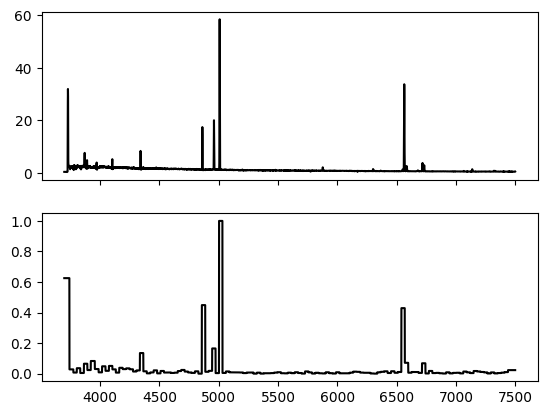

In [27]:
score_name = "mse_noRel100"
explanation_run_id = "20250427190650_uniform_5000_scale"

mse_weights = np.load(
    f"{explanations_dir}/{bin_id}/{score_name}/weights_{explanation_run_id}.npy",
    mmap_mode="r",
)

mse_spectra = np.load(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.npy",
    mmap_mode="r"
)

anomalies_df = pd.read_csv(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.csv.gz",
    index_col="specobjid",
)

# specobjid = 637325355518027776
specobjid = 3240467000396376064
idx = np.where(anomalies_df.index.values == specobjid)[0][0]

mse_weights = np.abs(mse_weights)
mse_weights /= np.max(mse_weights, axis=1, keepdims=True)

fig, axs = plt.subplots(2, 1, figsize=None, sharex=True)
axs[0].plot(wave, mse_spectra[idx, :], color="black")
axs[1].plot(wave, mse_weights[idx, :], color="black")

# MSE noRel 97

In [ ]:
score_name = "mse_noRel97"
explanation_run_id = "20250427151754_uniform_5000_scale"

anomalies_array = np.load(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.npy",
    mmap_mode="r"
)

anomalies_df = pd.read_csv(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.csv.gz",
    index_col="specobjid",
)

weights = ingest_explanations_into_array(
    specobjids_array=anomalies_df.index.values,
    wave=wave,
    load_from_dir=f"{explanations_dir}/{bin_id}/{score_name}/{explanation_run_id}",
)

np.save(
    f"{explanations_dir}/{bin_id}/{score_name}/weights_{explanation_run_id}.npy",
    weights,
)

# MSE 250kms noRel100

In [16]:
score_name = "mse_filter_250kms_noRel100"
explanation_run_id = "20250427094150_uniform_5000_scale"

anomalies_array = np.load(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.npy",
    mmap_mode="r"
)

anomalies_df = pd.read_csv(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.csv.gz",
    index_col="specobjid",
)

weights = ingest_explanations_into_array(
    specobjids_array=anomalies_df.index.values,
    wave=wave,
    load_from_dir=f"{explanations_dir}/{bin_id}/{score_name}/{explanation_run_id}",
)

np.save(
    f"{explanations_dir}/{bin_id}/{score_name}/weights_{explanation_run_id}.npy",
    weights,
)

# MSE 250kms noRel97

In [15]:
score_name = "mse_filter_250kms_noRel97"
explanation_run_id = "20250427105355_uniform_5000_scale"

anomalies_array = np.load(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.npy",
    mmap_mode="r"
)

anomalies_df = pd.read_csv(
    f"{spectra_dir}/{bin_id}/{score_name}/top_anomalies.csv.gz",
    index_col="specobjid",
)

weights = ingest_explanations_into_array(
    specobjids_array=anomalies_df.index.values,
    wave=wave,
    load_from_dir=f"{explanations_dir}/{bin_id}/{score_name}/{explanation_run_id}",
)

np.save(
    f"{explanations_dir}/{bin_id}/{score_name}/weights_{explanation_run_id}.npy",
    weights,
)